In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required libraries
!pip install -q scikit-learn imbalanced-learn xgboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/Fraud.csv')

In [4]:
print(df.shape)
print(df.info())
print(df.head())

(6362620, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        4155

In [5]:
# Check missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [5]:
df['isMerchant'] = df['nameDest'].str.startswith('M')

In [6]:
# Feature engineering for impossible balance (error flag)
df['errorBalanceFlag'] = (
    ((df['oldbalanceOrg'] == 0) & (df['newbalanceOrig'] == 0) & (df['amount'] != 0)) |
    ((df['oldbalanceDest'] == 0) & (df['newbalanceDest'] == 0) & (df['amount'] != 0) & (~df['isMerchant']))
).astype(int)

In [7]:
# Create difference features to reduce multicollinearity
df['balanceDiffOrig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['balanceDiffDest'] = df['newbalanceDest'] - df['oldbalanceDest']

In [8]:
# One-hot encode 'type' variable
df = pd.get_dummies(df, columns=['type'], drop_first=False)

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


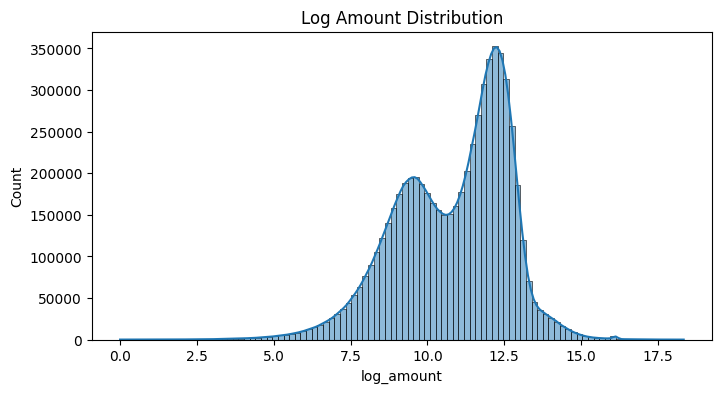

In [9]:
# Log-transform amount to handle skewness
df['log_amount'] = np.log1p(df['amount'])
# Explore fraud class imbalance
print(df['isFraud'].value_counts(normalize=True))

# Visualize 'amount' distribution (log scale)
plt.figure(figsize=(8,4))
sns.histplot(df['log_amount'], bins=100, kde=True)
plt.title('Log Amount Distribution')
plt.show()

In [10]:
# Features and target (adjust feature list if needed)
feature_cols = [
    'log_amount',
    'balanceDiffOrig',
    'balanceDiffDest',
    'errorBalanceFlag',
    'type_TRANSFER',
    'type_CASH_OUT',
]

X = df[feature_cols]
y = df['isFraud']

In [11]:
# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

In [22]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42, sampling_strategy=0.02)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Training samples before SMOTE: {X_train.shape[0]}")
print(f"Training samples after SMOTE: {X_train_res.shape[0]}")

Training samples before SMOTE: 4453834
Training samples after SMOTE: 4537046


In [13]:
# Initialize and train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42, max_depth=6, class_weight='balanced')
dt_model.fit(X_train_res, y_train_res)

DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=42)

In [23]:
# Predict on test set
y_pred = dt_model.predict(X_test)
y_probs = dt_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision (AUC-PR): {pr_auc:.4f}")

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97   1906322
           1       0.02      0.99      0.04      2464

    accuracy                           0.94   1908786
   macro avg       0.51      0.97      0.51   1908786
weighted avg       1.00      0.94      0.97   1908786

ROC AUC: 0.9921
Average Precision (AUC-PR): 0.6025


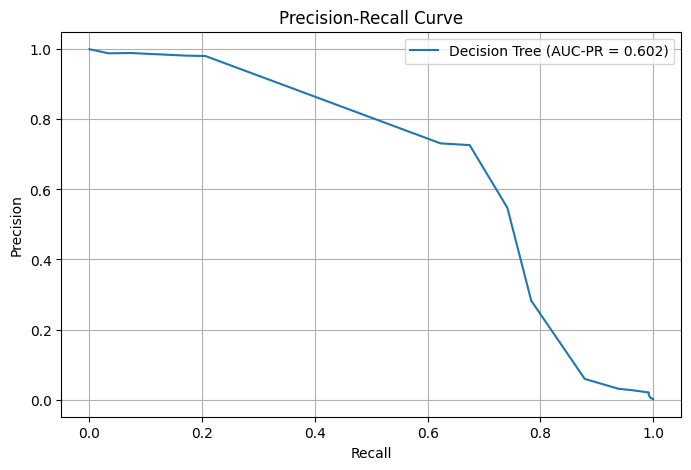

In [24]:
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_probs)
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label='Decision Tree (AUC-PR = {:.3f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [25]:
num_pos = sum(y_train == 1)
num_neg = sum(y_train == 0)
imbalance_ratio = num_neg / num_pos
print(f"Imbalance ratio (neg/pos): {imbalance_ratio}")


Imbalance ratio (neg/pos): 773.7145590537485


In [26]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

params = {'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1], 'n_estimators': [100, 300]}
xgb_clf = xgb.XGBClassifier(scale_pos_weight=imbalance_ratio, use_label_encoder=False, eval_metric='logloss', random_state=42)

random_search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=params,
    n_iter=5,
    scoring='average_precision',
    cv=3,
    verbose=2,
    n_jobs=-1
)
random_search.fit(X_train_res, y_train_res)

# Predict on test
y_probs = random_search.best_estimator_.predict_proba(X_test)[:, 1]

# Find threshold maximizing F1 or precision-recall
from sklearn.metrics import precision_recall_curve, f1_score
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
best_threshold = thresholds[f1_scores.argmax()]


Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:46:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [27]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_probs))  # use probs for AUC
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.940610943290657
ROC AUC: 0.992773348960125
Confusion Matrix:
 [[1792984  113338]
 [     23    2441]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97   1906322
           1       0.02      0.99      0.04      2464

    accuracy                           0.94   1908786
   macro avg       0.51      0.97      0.51   1908786
weighted avg       1.00      0.94      0.97   1908786



In [28]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.94      0.97   1906322
           1       0.02      0.99      0.04      2464

    accuracy                           0.94   1908786
   macro avg       0.51      0.97      0.51   1908786
weighted avg       1.00      0.94      0.97   1908786



In [29]:
from sklearn.metrics import average_precision_score

# Use precision-recall curve and manually test a few thresholds
for t in [0.90, 0.95, 0.98]:
    preds = (y_probs >= t).astype(int)
    print(f"Threshold: {t}")
    print(classification_report(y_test, preds))


Threshold: 0.9
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1906322
           1       0.03      0.98      0.06      2464

    accuracy                           0.96   1908786
   macro avg       0.52      0.97      0.52   1908786
weighted avg       1.00      0.96      0.98   1908786

Threshold: 0.95
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1906322
           1       0.03      0.97      0.07      2464

    accuracy                           0.96   1908786
   macro avg       0.52      0.97      0.52   1908786
weighted avg       1.00      0.96      0.98   1908786

Threshold: 0.98
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1906322
           1       0.05      0.93      0.09      2464

    accuracy                           0.97   1908786
   macro avg       0.52      0.95      0.54   1908786
weighted avg       1.00    